In [ ]:
import os, sys
os.chdir('../')
sys.path.append('../')

In [1]:
import data_handling
from data_specific import *
import model_creating, metrics
import torch, torch.nn as nn
import inference
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
import uncertainty as U
import pandas as pd

In [2]:
from importlib import reload

In [8]:
df = pd.read_csv('/mnt/tank/scratch/tpolevaya/dis_cv.csv')

In [9]:
df

,Name,epochs,save_folder,fold,augm,datasets,epoch
0,"hflip,saturation,cutout bs=50 lr=0.0001",30,logs/weights/run_20210614_134732,4,"hflip,saturation,cutout","chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm...",29
1,"hflip,saturation,cutout bs=50 lr=0.0001",100,logs/weights/run_20210614_083901,3,"hflip,saturation,cutout","chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm...",60
2,"hflip,saturation,cutout bs=50 lr=0.0001",100,logs/weights/run_20210613_233015,2,"hflip,saturation,cutout","chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm...",79
3,"hflip,saturation,cutout bs=50 lr=0.0001",100,logs/weights/run_20210613_232242,1,"hflip,saturation,cutout","chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm...",53
4,"hflip,saturation,cutout bs=50 lr=0.0001",100,logs/weights/run_20210613_231954,0,"hflip,saturation,cutout","chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm...",52


In [10]:
# def get_remaining_datasets(trn_datasets):
#     ds = data_handling.get_ds_names(True,False) + data_handling.get_ds_names(False,False)
#     ds = set(ds).difference(set(trn_datasets))
#     return sorted(ds)

In [11]:
datasets = df.iloc[0].datasets.split(',')
augm = df.iloc[0].augm

In [12]:
primary = np.array(['пятно+эритема', 'бугорок', 'узел', 'папула+бляшка+комедон', 'волдырь', 'пузырек', 'пузырь', 'гнойничок'])
diseases = np.array(['атопический дерматит', 'акне', 'псориаз', 'розацеа', 'бородавки', 'герпес', 'красный полский лишай', 'витилиго', 'аллергический контактный дерматит', 'экзема', 'дерматомикозы', 'буллезный пемфигоид', 'пузырчатка', 'контагиозный моллск', 'крапивница', 'себорейный кератоз', 'чесотка', 'себорейный дерматит', 'актинический кератоз', 'базалиома'])

In [15]:
','.join(datasets)

'chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm,hellenic,dermnetnz'

In [16]:
device = torch.device(f'cuda:0')
data = Data.Diseases
class_mode = get_class_mode(data)

In [18]:
base_ds = data_handling.create_val_ds(datasets, get_ds_class(data), 448, fold=0)

creating dataset from:  chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm,hellenic,dermnetnz


  0%|          | 0/3467 [00:00<?, ?it/s]

In [19]:
vanilla_dl = DataLoader(data_handling.AugmDataset(base_ds, None), batch_size=100, shuffle=False)
augm_dl = DataLoader(data_handling.AugmDataset(base_ds, augm), batch_size=100, shuffle=False)

In [20]:
def print_acc(preds, lbls):
    print(f'accuracy = {sklearn.metrics.accuracy_score(lbls, preds):.4f}')

In [21]:
def plot_cfm(preds, lbls):
    cfm = sklearn.metrics.confusion_matrix(lbls, preds)
    cfm_by_true = cfm.sum(axis=-1, keepdims=True)
    fig, ax = plt.subplots(figsize=(24,24))   
    sns.heatmap(cfm/cfm_by_true, annot=True, cmap='Blues', ax=ax)

## Evaluate one model

In [22]:
weight_folder = df.iloc[4].save_folder

In [23]:
m = model_creating.load_model(weight_folder, get_num_classes(data), device)

### Vanilla

In [24]:
probs, lbls = inference.predict(device, vanilla_dl, m, class_mode)
preds = probs.argmax(axis=-1)
print_acc(preds, lbls)

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

accuracy = 0.7101


#### cfm

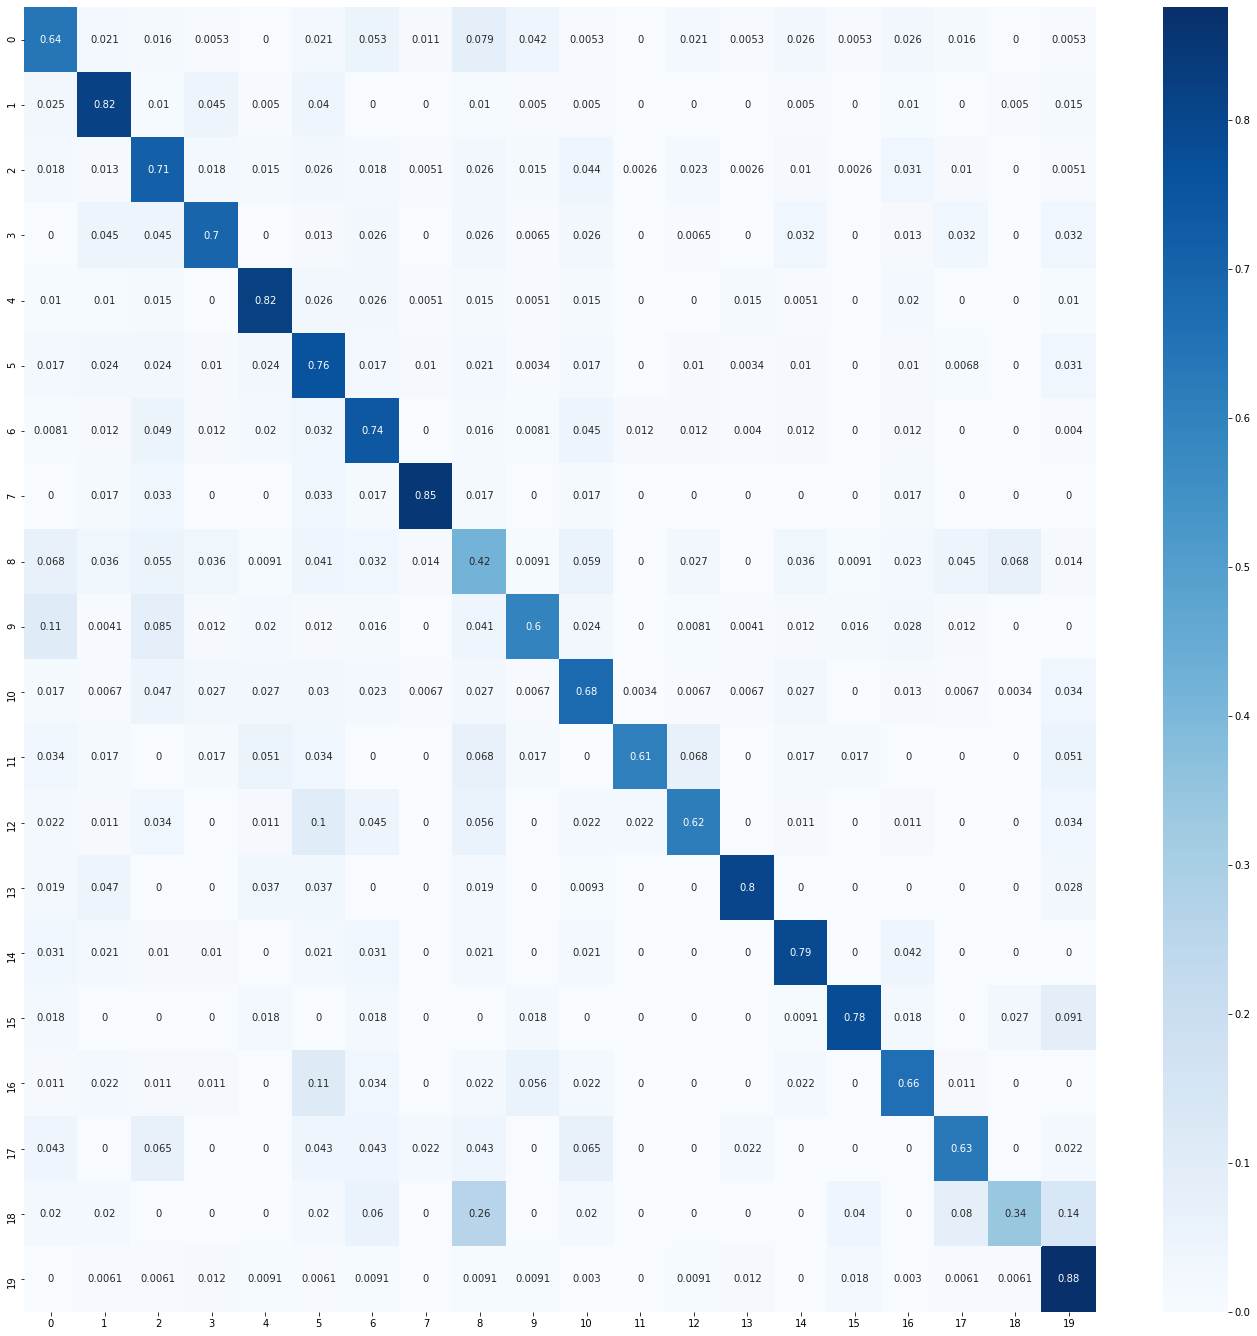

In [25]:
plot_cfm(preds, lbls)

### With TTA

In [26]:
all_probs, all_lbls = inference.predict_TTA(device, augm_dl, m, class_mode, num_augm=10)

Augm:   0%|          | 0/10 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

Inference:   0%|          | 0/35 [00:00<?, ?it/s]

In [27]:
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]

In [28]:
print_acc(preds, lbls)

accuracy = 0.7211


#### cfm

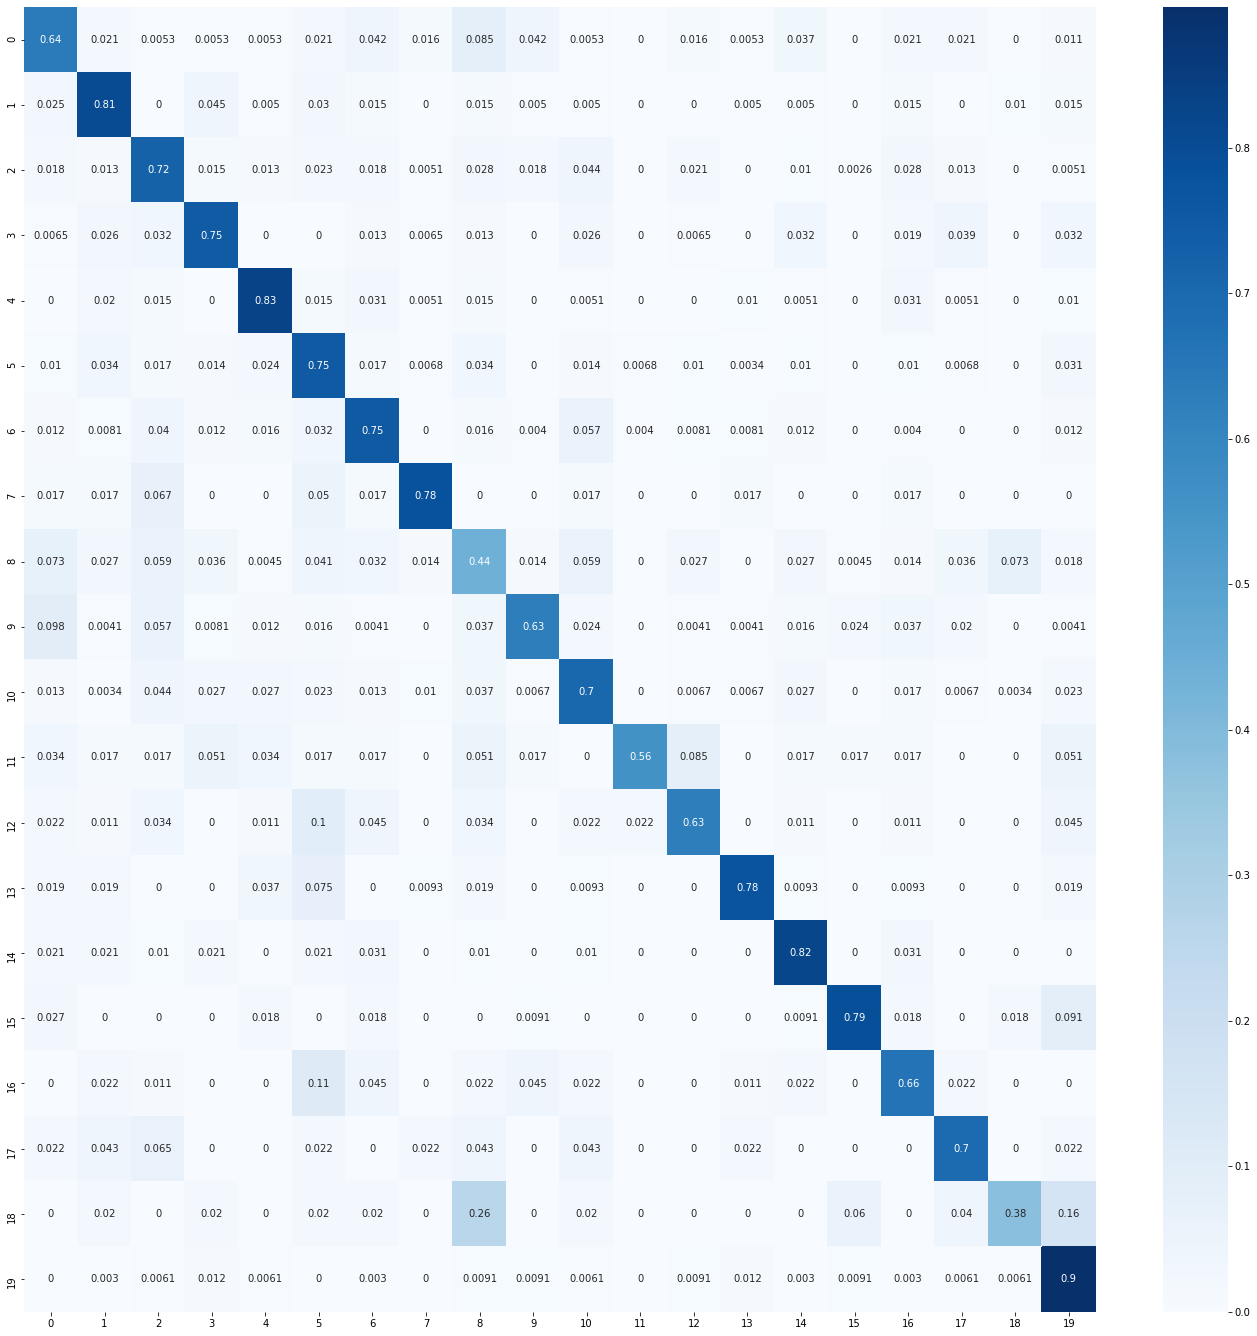

In [29]:
plot_cfm(preds, lbls)

#### Uncertainty

In [31]:
totalU, dataU, knowU = U.get_uncertainties(all_probs, all_lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


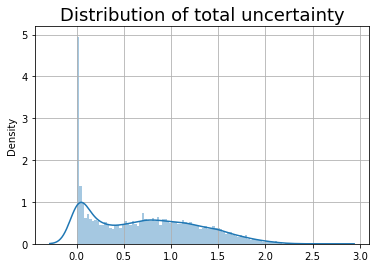

In [32]:
U.plot_totalU(totalU)

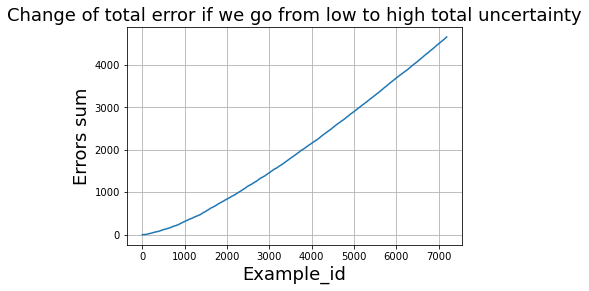

In [33]:
errors = (preds != lbls)
U.plot_error_change(errors, totalU)

## Evaluate ensemble

In [46]:
fldrs = ['logs/weights/run_20210606_133148',
         'logs/weights/run_20210606_133109',
         'logs/weights/run_20210606_133100']
models = [model_creating.load_model(fldr, get_num_classes(data), device) for fldr in fldrs]

## Vanilla

In [47]:
all_probs, all_lbls = inference.predict_ensemble(device, vanilla_dl, models, class_mode)

Model:   0%|          | 0/3 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

In [48]:
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]

In [49]:
print_acc(preds, lbls)

accuracy = 0.3063


#### cfm

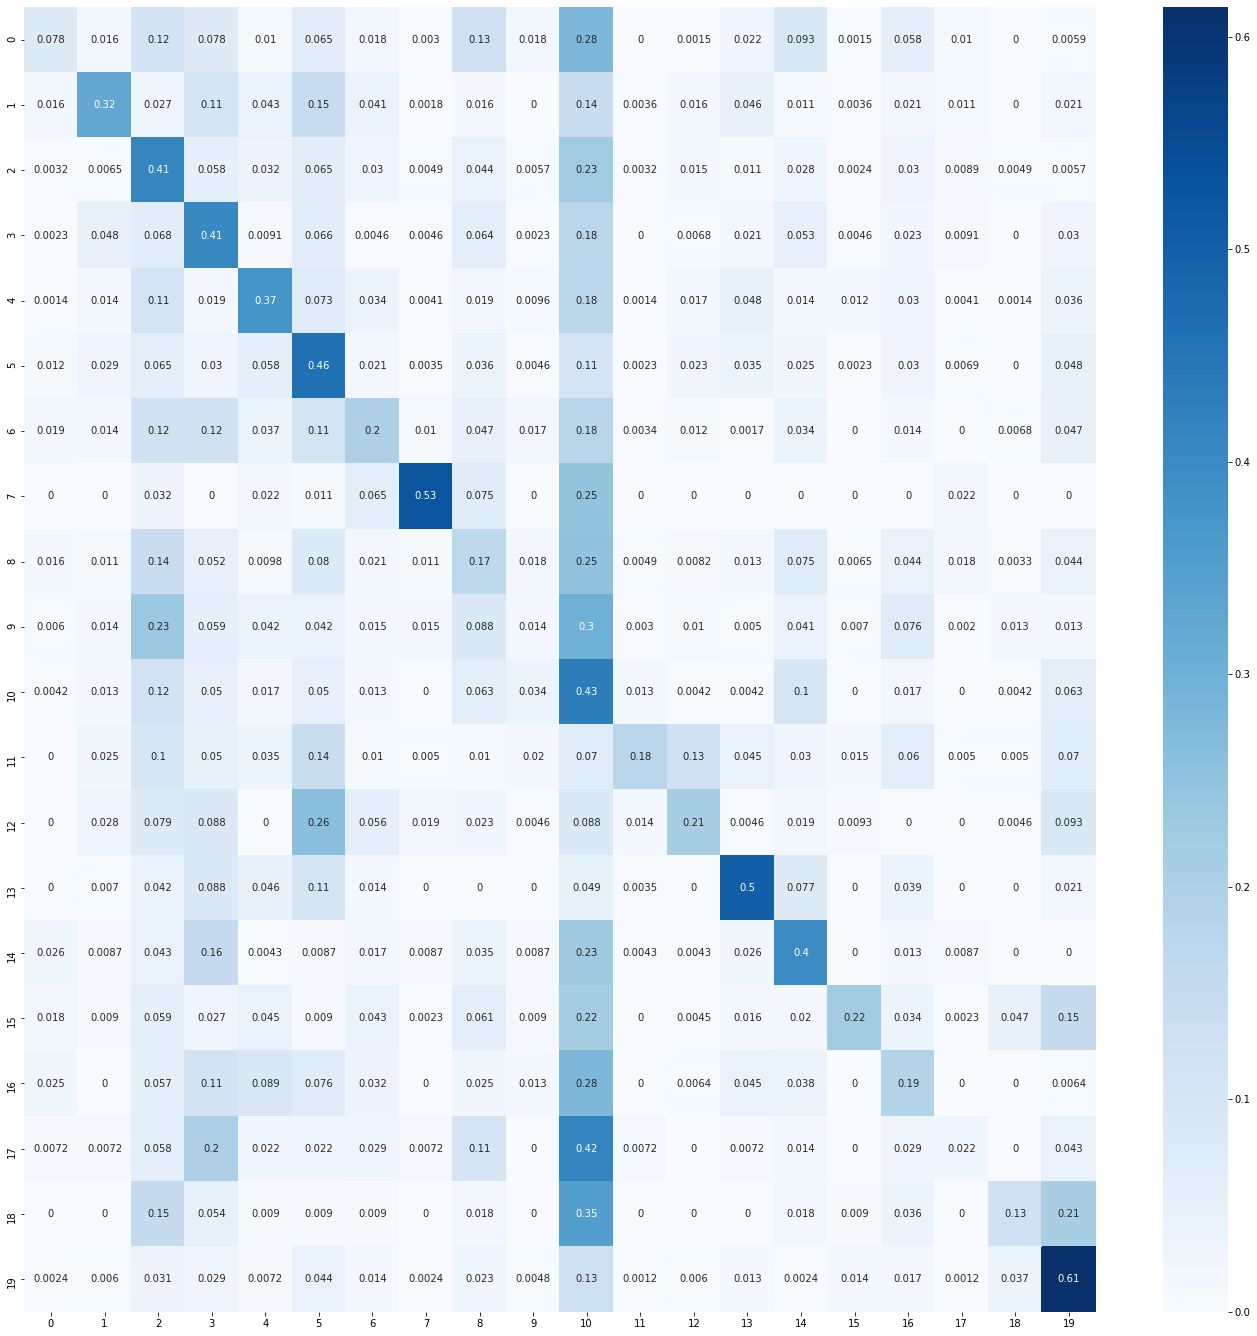

In [50]:
plot_cfm(preds, lbls)

#### Uncertainty

In [51]:
totalU, dataU, knowU = U.get_uncertainties(all_probs, all_lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


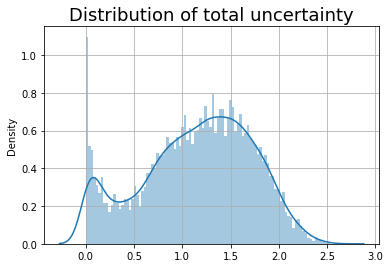

In [52]:
U.plot_totalU(totalU)

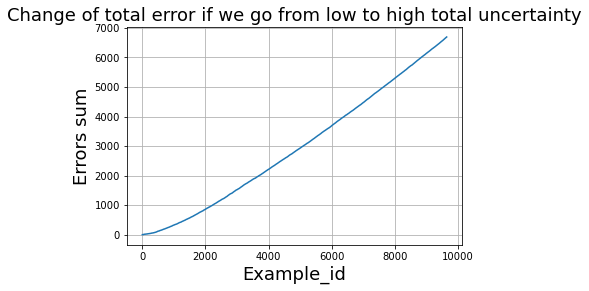

In [53]:
errors = (preds != lbls)
U.plot_error_change(errors, totalU)

### With TTA

In [54]:
all_probs, all_lbls = inference.predict_ensemble_TTA(device, hflip_dl, models, class_mode, num_augm=2)

Model:   0%|          | 0/3 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

Inference:   0%|          | 0/97 [00:00<?, ?it/s]

In [55]:
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]

In [56]:
print_acc(preds, lbls)

accuracy = 0.3142


#### cfm

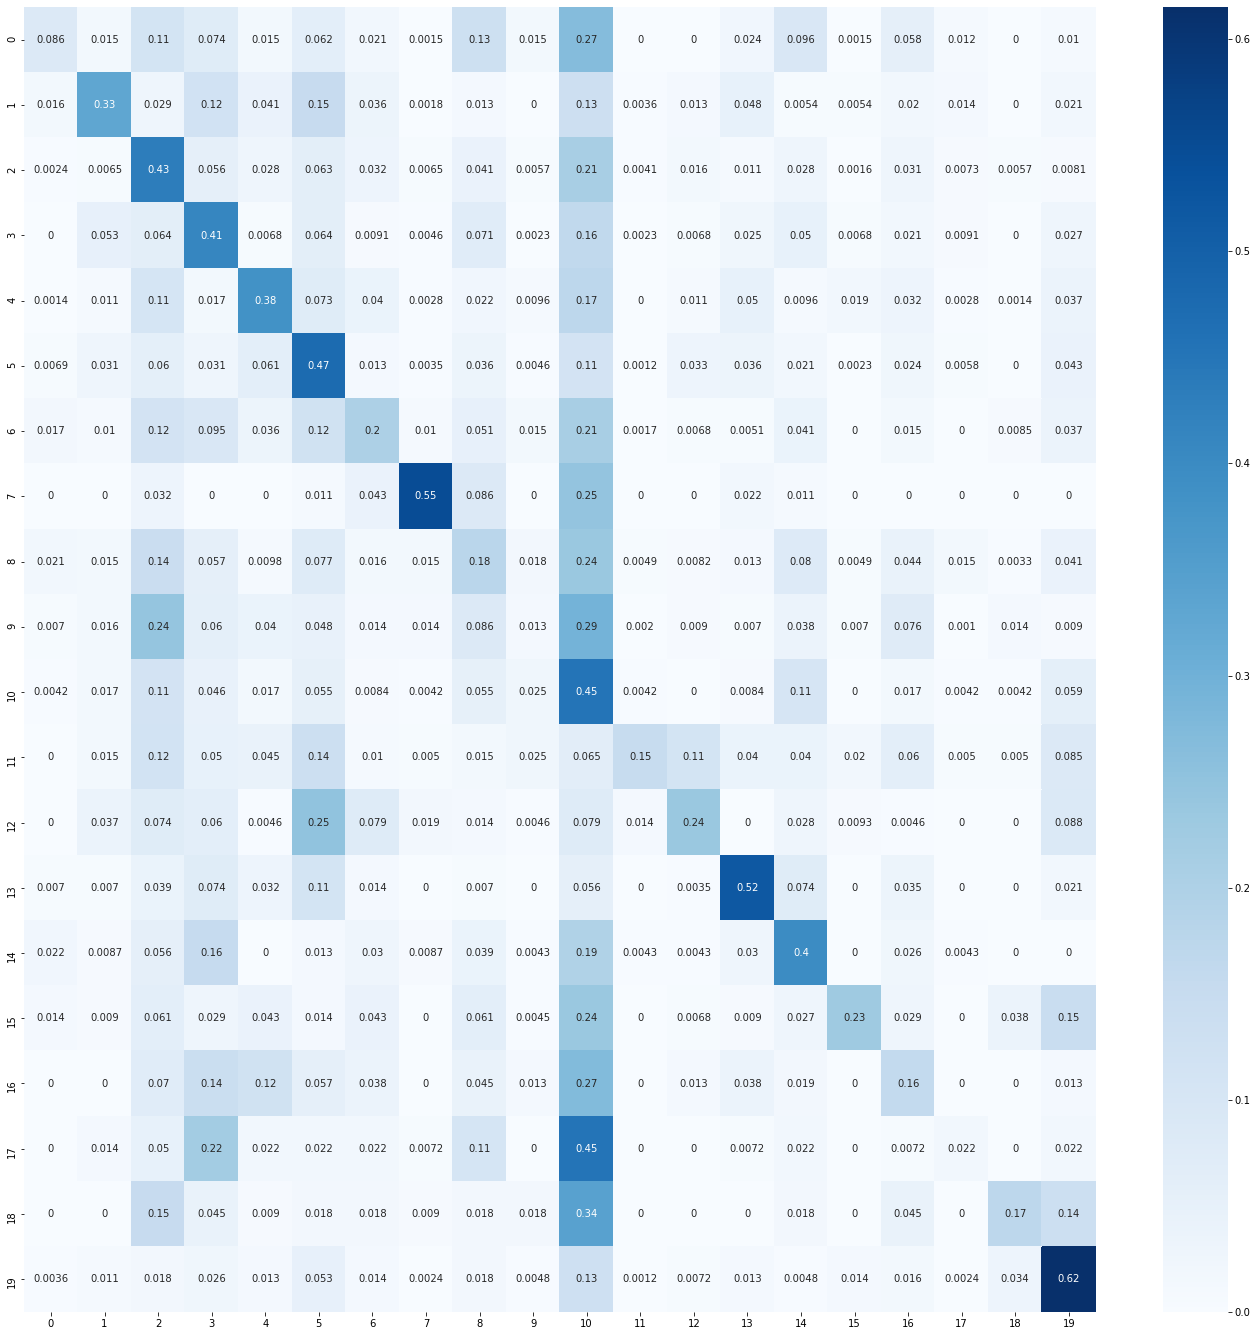

In [57]:
plot_cfm(preds, lbls)

#### Uncertainty

In [58]:
totalU, dataU, knowU = U.get_uncertainties(all_probs, all_lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


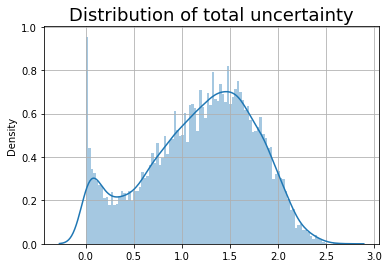

In [59]:
U.plot_totalU(totalU)